#### Solution
##### Data analysis to understand which companies are likely to adopt Artificial Intelligence (AI) in the near future.

In [1]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from rank_bm25 import BM25Okapi
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##### 1. Load the dataset

In [2]:
df = pd.read_csv("data/Sample_Data_Job_Descriptions.csv")

##### 2. Data Cleaning:
- Makes everything lowercase.
- Removes newlines, tabs, and extra whitespace.
- Removes field-style labels like "Position Title: ", "Department: ", etc.
- Removes bullet characters (common in JDs).
- Removes special characters except letters, numbers, spaces, periods, and commas.
- Tokenization, Stopword Removal, Lemmatization

In [3]:
# Load resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # Only use tagger

def clean_jd(text):
    # Lowercase and basic formatting
    text = text.lower()
    text = re.sub(r'[\n\r\t]+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'\b[a-z ]{1,30}:\s', '', text)  # Remove field labels
    text = re.sub(r'[•\-–\*●]', '', text)
    
    # Remove known irrelevant sections
    irrelevant_patterns = [
        r'equal opportunity employer.*?(?=\.\s|$)',
        r'visa sponsorship.*?(?=\.\s|$)',
        r'physical skills and abilities.*?(?=skills|other)',
        r'cognitive and other skills.*?(?=required|preferred)',
        r'working conditions.*?(?=candidates|careoregon)',
    ]
    for pattern in irrelevant_patterns:
        text = re.sub(pattern, '', text, flags=re.DOTALL)

    # Remove special characters except periods and commas
    text = re.sub(r'[^\w\s.,]', '', text)

    # Tokenization + Lemmatization + Stopword removal
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words and token.is_alpha and len(token.lemma_) > 2
    ]

    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/vishal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df['clean_jd'] = df['Job Description'].apply(clean_jd)

##### 3. Visualization
- 3.1 Bar Chart : showing the top N companies with the most job descriptions in a given DataFrame.

/tmp/ipykernel_11774/1139969699.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=company_counts, x='Company Name', y='Count', palette='Blues_d', legend=False)


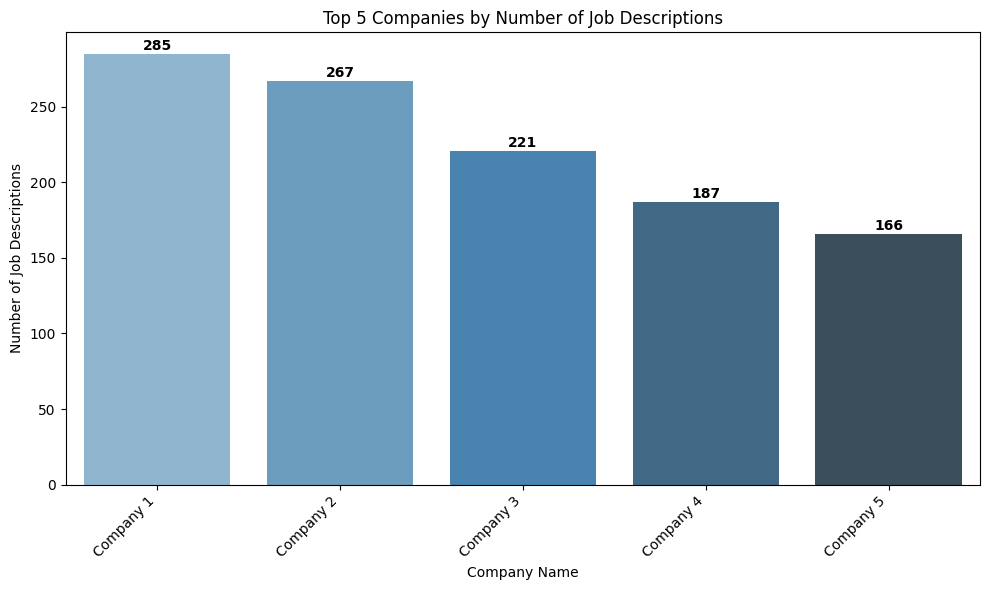

In [5]:
def plot_top_companies(df, column='Company Name', top_n=5):
    company_counts = df[column].value_counts().head(top_n).reset_index()
    company_counts.columns = ['Company Name', 'Count']

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=company_counts, x='Company Name', y='Count', palette='Blues_d', legend=False)

    for i, row in company_counts.iterrows():
        ax.text(i, row['Count'] + 0.5, row['Count'], ha='center', va='bottom', fontweight='bold')

    plt.title(f'Top {top_n} Companies by Number of Job Descriptions')
    plt.xlabel('Company Name')
    plt.ylabel('Number of Job Descriptions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_top_companies(df)

- 3.2 WordCloud : word cloud from the job descriptions text and visualizes it for each company

In [6]:
from wordcloud import WordCloud
def generate_wordcloud(text, company_name, output_folder="data"):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f" WordCloud: {company_name}")
    plt.show()

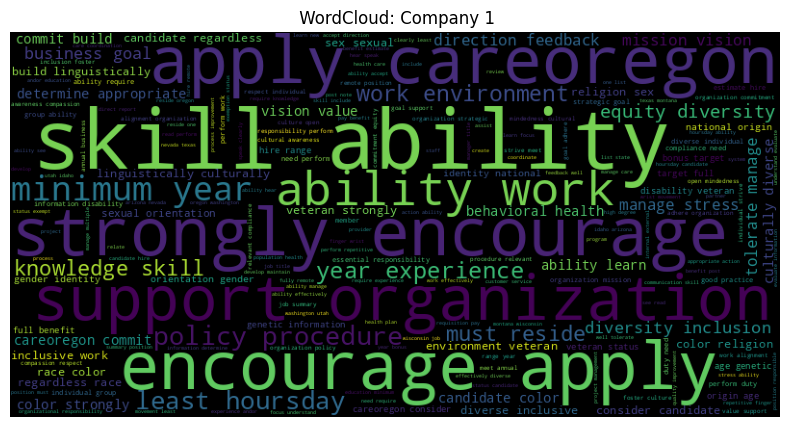

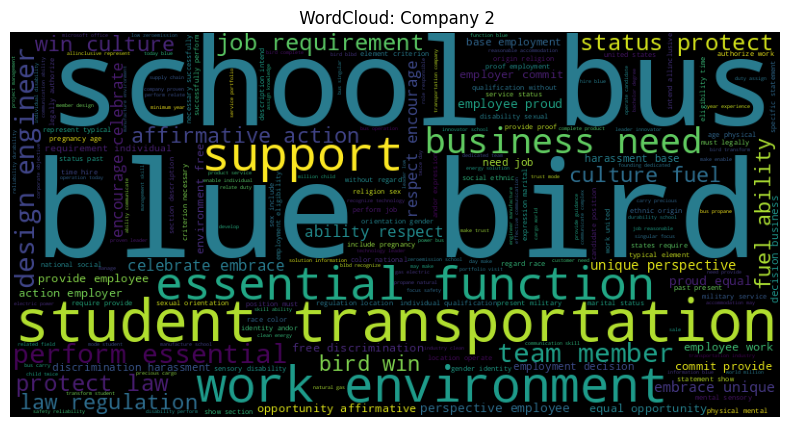

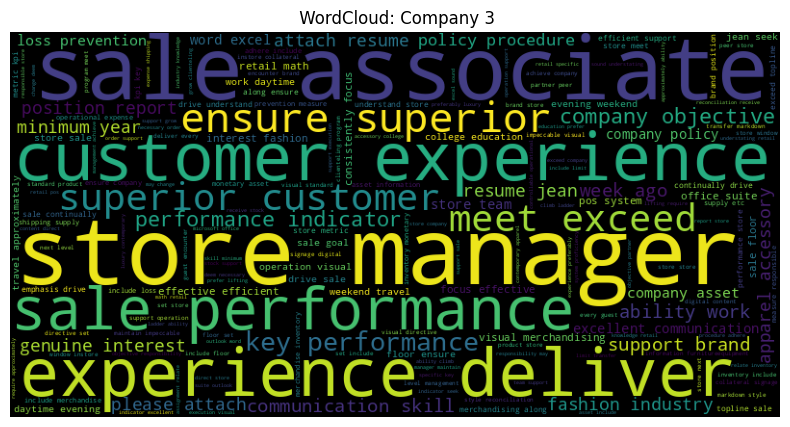

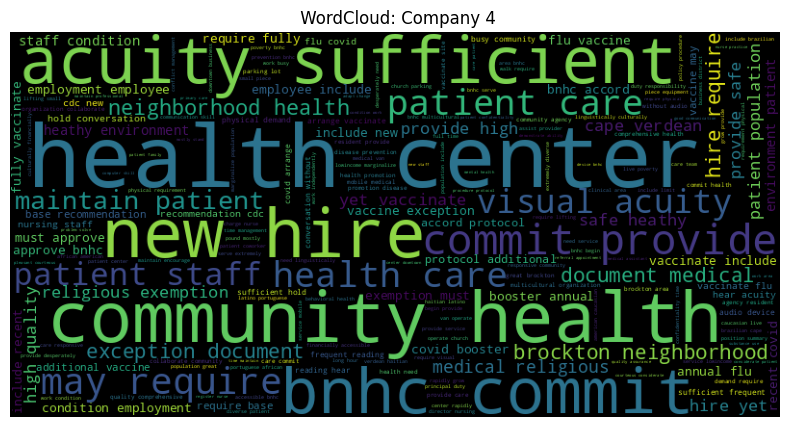

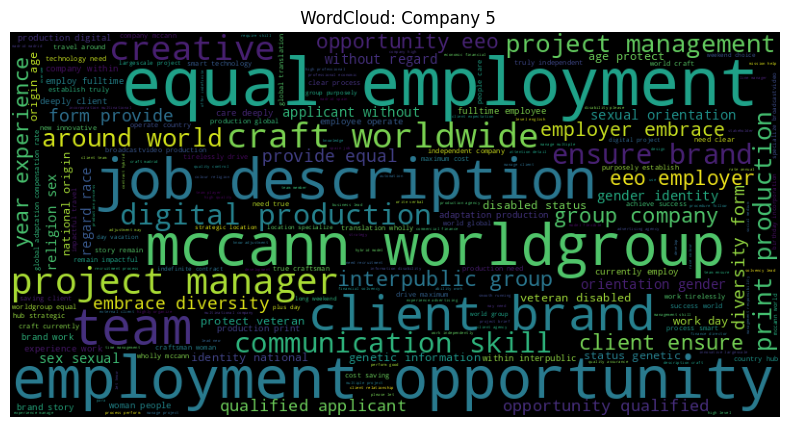

In [7]:
# sampled_df = df.groupby('Company Name').apply(lambda x: x.sample(n=5, random_state=42)).reset_index(drop=True)
grouped_df_dict = df.groupby('Company Name')['clean_jd'].apply(lambda x: ' '.join(x)).to_dict()
for cmp in grouped_df_dict.keys():
    generate_wordcloud(grouped_df_dict[cmp], cmp)


#### 4. Scoring:
- Computes BM25 relevance scores for job descriptions against the keyword list.
- Normalizes the relevance score of a single job description to a scale of 0–10 and returns it.

In [8]:
nltk.download('punkt')

ai_ml_ds_keywords = [
    "data science", "data scientist", "data analyst", "data analysis", "data mining",
    "statistical analysis", "statistics", "probability", "hypothesis testing",
    "regression", "linear regression", "logistic regression",
    "classification", "clustering", "time series", "forecasting", "feature engineering",

    "ds", "ml", "ai", "dl", "llm", "nlp", "cv",
    
    "python", "r", "sql", "excel", "pandas", "numpy", "scipy", "scikit-learn", "sklearn",
    "matplotlib", "seaborn", "statsmodels", "jupyter", "notebook",
    
    "machine learning", "supervised learning", "unsupervised learning",
    "knn", "k-nearest neighbors", "svm", "support vector machine", "decision tree",
    "random forest", "xgboost", "lightgbm", "catboost", "model evaluation",
    "cross validation", "roc curve", "precision", "recall", "f1 score",

    "deep learning", "neural networks", "cnn", "rnn", "transformers", "attention mechanism",
    "generative ai", "genai", "llms", "large language models", "prompt engineering",
    "gpt", "chatgpt", "bert", "gpt-3", "gpt-4", "openai", "huggingface",

    "tensorflow", "keras", "pytorch", "torch", "onnx", "autodiff",

    "natural language processing", "text mining", "text analytics", "sentiment analysis",
    "topic modeling", "tf-idf", "word2vec", "glove", "tokenization", "lemmatization",

    "data visualization", "plotly", "tableau", "power bi", "looker", "dash", "qlik", "ggplot",

    "big data", "hadoop", "spark", "hive", "kafka", "airflow", "etl", "data pipeline",
    "aws", "azure", "gcp", "databricks", "s3", "redshift", "snowflake",

    "a/b testing", "experimentation", "kpi", "metrics", "bi", "business intelligence",
    "product analytics", "customer analytics", "financial modeling", "market analysis"
]

### Compute normalized BM25 score (0–10) for a single JD using AI/ML/DS keywords.
def get_normalized_bm25_score_for_one(jd_text):
    tokenized_corpus = [word_tokenize(doc.lower()) for doc in corpus_texts]
    bm25 = BM25Okapi(tokenized_corpus)
    raw_scores = bm25.get_scores(keyword_query)
    min_score = np.min(raw_scores)
    max_score = np.max(raw_scores)
    try:
        target_index = corpus_texts.index(jd_text)
    except ValueError:
        raise ValueError("JD not found in the corpus. Please include the JD in corpus_texts.")

    if max_score == min_score:
        return 5.0  # All JDs scored the same, so return midpoint
    else:
        normalized_score = 10 * (raw_scores[target_index] - min_score) / (max_score - min_score)
        return round(normalized_score, 2)


[nltk_data] Downloading package punkt to /home/vishal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
keyword_query = word_tokenize(" ".join(ai_ml_ds_keywords).lower())
corpus_texts = list(df['clean_jd'])

In [ ]:
df['jd_score'] = df['clean_jd'].apply(get_normalized_bm25_score_for_one)

In [ ]:
df.head()

##### 5: Claculate AI_Adoption_Readiness

In [ ]:
avg_score_all = df.groupby('Company Name')['jd_score'].mean().reset_index()
avg_score_all.columns = ['Company Name', 'Avg_JD_Score_All']
top_N_avg = (
    df.sort_values(['Company Name', 'jd_score'], ascending=[True, False])  
      .groupby('Company Name', group_keys=False)
      .head(100) # take top 100 scores per company
      .groupby('Company Name')['jd_score']
      .mean()
      .reset_index()
      .rename(columns={'jd_score': 'Avg_Top_N_JD_Score'})
)
avg_combined = pd.merge(avg_score_all, top_N_avg, on='Company Name')
avg_combined["AI_Adoption_Readiness"] = avg_combined['Avg_Top100_JD_Score'].apply(lambda x: 'Yes' if x > 5 else 'No')

In [ ]:
avg_combined.head()